## Probability Density Function (PDF) Estimation 

A random variable x has a probability distribution $ p(x) $.

Common probability distributions include uniform, normal, exponential, binomial, poisson, etc.



In [1]:
######################################################
##
## Probability Density Function (PDF) Estimation
##
######################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap
from numpy.random import normal
from scipy.stats import norm
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 50000
batch_size = 10
learning_rate =  0.01    ## 0.01   ## 1e-5 

## probably need adjustable learning rate scheduler

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

## The Histogram

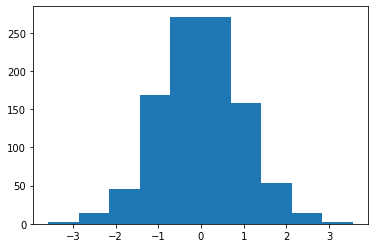

In [2]:

sample = normal(size=1000)


plt.hist(sample, bins=10)
plt.show()


## Parametric Density Estimation

First identify one of the common probability distributions, and then you estimate the parameters for it. 

In [3]:

## loc -> mean -> 50
## scale -> standard deviation -> 5

sample = normal(loc=50, scale=5, size=1000)

In [4]:
## calculate parameters

sample_mean         = np.mean(sample)
sample_standard_dev = np.std(sample)

print('mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_standard_dev))

mean=49.913, Standard Deviation=4.836


## Define the normal distribution function with learned parameters



In [5]:


dist = norm(sample_mean, sample_standard_dev)



## Now sample probabilities from this distribution for a range of values

In [6]:
## sample probabilities for a range of values

values = [value for value in range(30 ,70)]

probabilities = [dist.pdf(value) for value in values]

print(probabilities)


[1.7187558099923707e-05, 3.941388564941389e-05, 8.660001892838958e-05, 0.00018231415266619435, 0.0003677531839115066, 0.0007107652084864507, 0.0013162232036428123, 0.0023354285544449883, 0.003970427687659962, 0.006467577735344059, 0.010094380836223613, 0.015095634622188683, 0.021630010346917916, 0.02969584861251574, 0.039063253824982, 0.049235091836506324, 0.05945860980119668, 0.06879999567035965, 0.07627737392169608, 0.08102829792884347, 0.0824729181409151, 0.08043029626029426, 0.07515565030711517, 0.06728794536339587, 0.057722689653847886, 0.04744489753429541, 0.037365098239722755, 0.028195279592025373, 0.020385451950782594, 0.014122056503243087, 0.00937366021967774, 0.005961480543159064, 0.0036327266205930775, 0.0021210209768539766, 0.0011865631935480418, 0.0006360195179386314, 0.0003266507620357276, 0.00016074244491961026, 7.578986360363818e-05, 3.423933671491936e-05]


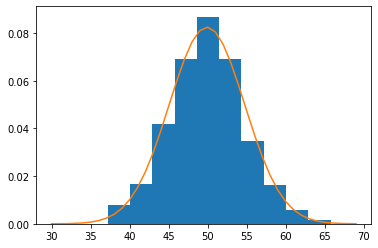

In [7]:

## plot the histogram and PDF

## plt.hist(sample, bins=10)                       ## shows the count
plt.hist(sample, bins=10, density=True)      ## shows a normalized probability instead of counts
plt.plot(values, probabilities)
plt.show()



## Nonparametric Density Estimation

This approach is useful when there is no clear distribution from observation but you can still create a pdf.

Possibly, the most common non-parametric approach for estimating the PDF of a random variable is "Kernel Smoothing" or "Kernel Density Estimation (KDE)". In this case, a kernel is a mathematical function that returns a probability for a given value of a random variable. 

I think this is a sum of basis functions to approximate a new PDF function where the area equals to 1. 

## First generate the data with no clear known distribution

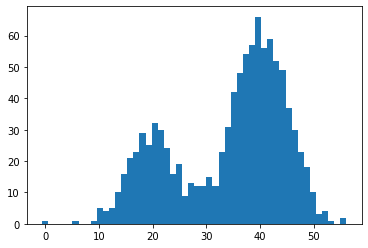

In [8]:

sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)

sample = hstack((sample1, sample2))
plt.hist(sample, bins=50)
plt.show()


## Now perform Kernel Density Estimation on this data to find the PDF

The data needs to have a 2D shape in the form (rows, columns).

In [9]:

## Bandwidth (smoothing parameter) is a window size required by the algorithm that controls 
## the number of observations (samples) to look at per new point to estimate. 
## The kernel is the basis function. 

model = KernelDensity(bandwidth=2, kernel='gaussian')

sample = sample.reshape((len(sample), 1))              ## 1000x1

model.fit(sample)


KernelDensity(bandwidth=2)

## Now compare the estimated PDF to the histogram

The model calculates the log probability for the input data with model.score_samples(). We then need to invert the log operation by calculating the exponent to return the values to the 0-1 range for normal probabilities. 

if

$ \large log_a b = c  $


then

$ \large a^c = b $

The irrational number $ e $ is also known as Euler’s number. It is approximately 2.718281, and is the base of the natural logarithm (ln). This means that, if 

$ \large x = \ln y = log_{e} y  $ 


then 

$  \large e^x = y  $


For real input, exp(x) is always positive.

In [10]:
values = asarray([value for value in range(1, 60)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
print(probabilities)

[-8.72160332 -8.91120356 -8.84941128 -8.55724127 -8.2203527  -7.84445673
 -7.35688874 -6.79688409 -6.26619867 -5.81292192 -5.42769216 -5.08205901
 -4.76186073 -4.47543392 -4.23702097 -4.05132458 -3.91294071 -3.81407688
 -3.7514596  -3.72843211 -3.75163176 -3.824226   -3.94055492 -4.08560137
 -4.23696    -4.36639272 -4.44662452 -4.46509402 -4.42565578 -4.33314983
 -4.18732175 -3.99495689 -3.77825668 -3.56644515 -3.38234363 -3.23596629
 -3.12599006 -3.04620064 -2.99292649 -2.96812921 -2.97653726 -3.02121522
 -3.10174634 -3.2152831  -3.35907938 -3.53286198 -3.73977539 -3.98654347
 -4.28316759 -4.6392272  -5.05587006 -5.51998034 -6.00693334 -6.48701365
 -6.93359777 -7.35098029 -7.79790182 -8.35689648 -9.09175513]


In [11]:
## now invert from log space to exponent space 

probabilities = exp(probabilities)
print(probabilities)

[0.00016303 0.00013487 0.00014347 0.00019215 0.00026912 0.00039192
 0.00063818 0.00111725 0.00189944 0.00298868 0.00439322 0.00620712
 0.00854969 0.01138528 0.01445058 0.01739931 0.01998165 0.02205807
 0.02348344 0.02403048 0.0234794  0.02183533 0.01943743 0.01681303
 0.01445146 0.01269696 0.01171805 0.01150361 0.01196636 0.01312614
 0.0151869  0.01840824 0.02286251 0.02825612 0.03396775 0.03932219
 0.04389345 0.0475392  0.05014049 0.05139938 0.05096902 0.04874195
 0.0449706  0.04014397 0.03476725 0.02922117 0.02375944 0.01856377
 0.01379888 0.00966516 0.00637182 0.00400593 0.00246163 0.00152309
 0.00097449 0.00064196 0.0004106  0.00023477 0.00011259]


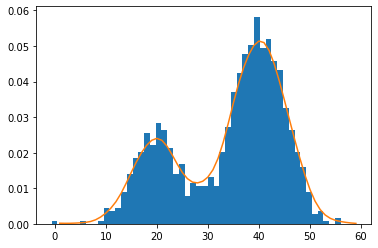

In [12]:

plt.hist(sample, bins=50, density=True)     ## see probs instead of counts with density=True
plt.plot(values[:], probabilities)          ## reshaped to 2D
plt.show()
